# Connecting Symuvia via Python 

This notebook explains the way a simple connection is created from `Python` towards `Symuvia`. In this case a simple simulation is run step by step and data is retrieved and stored within a `sqlite` file. At end data is imported and trajectories are plotted 

In [47]:
import os 
from ctypes import cdll, create_string_buffer, c_int, byref, c_bool


from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, String, Integer, Float 
from sqlalchemy import insert, delete, select, case, and_

from xmltodict import parse
from collections import OrderedDict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bokeh
from bokeh.plotting import figure, show
from bokeh.sampledata.iris import flowers
from bokeh.io import output_notebook
output_notebook() 

# Plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# import altair as alt
# alt.renderers.enable('default')
# print(alt.renderers.active)

# from vega_datasets import data as data_vega

# import seaborn as sns
from bokeh.plotting import figure, show, output_file


Loading BokehJS ...

Traffic parameters 

In [48]:
KC = 0.16
KH = 0.0896
VF = 25.0
W = 6.25
E  = 25.0*0.3
GCAV = 1/(KC*W)
GHDV = 1/(KH*W)
SCAV = VF/(KC*W)+1/KC
SHDV = VF/(KH*W)+1/KH
dveh_twy = {'CAV': GCAV, 'HDV': GHDV}
dveh_dwy = {'CAV': 1/KC, 'HDV': 1/KH}
U_MAX = 1.5
U_MIN = -1.5

## Connect Symuvia 

In this case connect to the simulator. First define the `libSymuVia.dylib` file 

In [49]:
dir_path = os.getcwd()
lib_path_name = ('..','Symuvia','Contents','Frameworks','libSymuVia.dylib')

In [50]:
full_name = os.path.join(dir_path,*lib_path_name)

Load the lybrary

In [51]:
symuvialib = cdll.LoadLibrary(full_name)     

Determine the full path of the file to be simulated 

In [52]:
file_path = ('..', 'Network', 'Merge.xml')
file_name = os.path.join(dir_path, *file_path)

### Launching the symulation 

Load the network 

In [53]:
m = symuvialib.SymLoadNetworkEx(file_name.encode('UTF8'))

Check creation / load database 

In [54]:
engine_path = ('..','Output','SymOut.sqlite')
engine_name = os.path.join(os.path.sep,*engine_path)
engine_full_name = os.path.join(dir_path,*engine_path)
engine_call = 'sqlite://'+engine_name
engine = create_engine(engine_call)
metadata = MetaData()

try: 
    ltbstr = 'Loaded table in: '
    connection = engine.connect()    
    traj = Table('traj', metadata, autoload=True, autoload_with=engine)
    stmt = delete(traj)
    results = connection.execute(stmt)
except:
    ltbstr = 'Loaded table in: '
    traj = Table('traj', metadata,
             Column('ti', Float()),
             Column('id', Integer()),
             Column('type', String(3)),
             Column('tron', String(10)),
             Column('voie', Integer()),
             Column('dst', Float()),
             Column('abs', Float()),
             Column('vit', Float()),
             Column('ldr', Integer()),
             Column('spc', Float()),
             Column('vld', Float()))
    metadata.create_all(engine)
    connection = engine.connect()
finally: 
    print(ltbstr, engine)

Loaded table in:  Engine(sqlite:///../Output/SymOut.sqlite)


Create pointers to retrieve data 

In [55]:
sRequest = create_string_buffer(10000)
bEnd = c_bool(False)
bSecond = c_bool(True)

Functions during running time 

In [56]:
# Parser data_vehicle
def typedict(veh_dict):
    data = {'id': int(veh_dict['@id']),
        'type': veh_dict['@type'],
        'tron': veh_dict['@tron'],
        'voie': int(veh_dict['@voie']),
        'dst': float(veh_dict['@dst']),
        'abs': float(veh_dict['@abs']),
        'vit': float(veh_dict['@vit']),
       }
    return data 

### Network information

Information regarding V2V communicatioin is computed. In particular which is the connectivity in this case only a single leader is identified 

In [57]:
# Identify Leader 

def queueveh(dLeader, veh):
    if veh['tron'] in dLeader.keys():
        if  veh['id'] not in dLeader[veh['tron']]:
            dLeader[veh['tron']].append(veh['id'])
    else:
        dLeader[veh['tron']] = [veh['id']]
    return dLeader 

def getlead(dLeader, veh):
    idx = dLeader[veh['tron']].index(veh['id'])
    if idx != 0:
        return dLeader[veh['tron']][idx-1]
    else: 
        return dLeader[veh['tron']][idx]
        

### Control information 

In this case functions to compute `spacing` and leaders' information is provided 

In [58]:
# Spacing 

def getspace(lTrajVeh):    
    
    # Equilibrium s
    det_eq_s = lambda x: SCAV if x['type']=='CAV' else SHDV
    
    try: 
        # Case single vehicle
        if lTrajVeh['id'] == lTrajVeh['ldr']:            
            return [{'spc':0.0+det_eq_s(lTrajVeh)}] 
        else:
            # Last vehicle
            # Leader out of Network @ ti
            return [{'spc':None}] 
    except (TypeError, IndexError):        
        # Multiple veh @ ti
        space = []
        for veh in lTrajVeh:
            if veh['id'] == veh['ldr']:
                space.append(0.0+det_eq_s(veh))
            else:             
                veh_pos = veh['abs']
                ldr_id = veh['ldr']
                ldr_pos = [ldr['abs'] for ldr in lTrajVeh if ldr['id']==ldr_id]
                if ldr_pos:
                    space.append(ldr_pos[0]-veh_pos)
                else:
                    # Leader out of Network @ ti
                    space.append(0.0)
        space_dct = [{'spc': val} for val in space]
        return space_dct

def getleaderspeed(lTrajVeh):
    try: 
        # Case single vehicle
        if lTrajVeh['id'] == lTrajVeh['ldr']:
            return [{'vld': lTrajVeh['vit']}]
        else:
            # Leader out of Network @ ti
            return [{'vld':None}]                     
    except (TypeError, IndexError):        
        # Multiple veh @ ti
        speedldr = []
        for veh in lTrajVeh:
            if veh['id'] == veh['ldr']:
                speedldr.append(veh['vit'])
            else:             
                ldr_id = veh['ldr']
                ldr_vit = [ldr['vit'] for ldr in lTrajVeh if ldr['id']==ldr_id]
                if ldr_vit:
                    speedldr.append(ldr_vit[0])
                else:
                    speedldr.append(veh['vit'])
        speedldr_dct = [{'vld': val} for val in speedldr]
        return speedldr_dct    
    
def updatelist(lTrajVeh,lDict):
    try:
        lTrajVeh.update(lDict[0])
    except AttributeError:
        for d,s in zip(lTrajVeh,lDict):
            d.update(s)
    return lTrajVeh



Iterate step by step over the simulation

In [59]:
N = 800 # Simulation steps

# Start simulation from beginning
m = symuvialib.SymLoadNetworkEx(file_name.encode('UTF8'))

# Clean table
stmt = delete(traj)
results = connection.execute(stmt)

step = iter(range(N)) 
stmt = insert(traj)

t = []

#for step in steps: 
bSuccess = 2 
while bSuccess>0:
    try:
        next(step)
        bSuccess =  symuvialib.SymRunNextStepEx(sRequest, True, byref(bEnd))
        dParsed = parse(sRequest.value.decode('UTF8'))
        ti = dParsed['INST']['@val']
        if dParsed['INST']['TRAJS'] is None:
            print('No vehicles in the network at time: {}'.format(ti))
        else:            
            lVehOD = dParsed['INST']['TRAJS']['TRAJ']      
            lTrajVeh = []
            try:
                lTrajVeh = typedict(lVehOD)
                lTrajVeh['ti'] = ti
                dLeader = {lTrajVeh['tron']: [lTrajVeh['id']]}
                lTrajVeh['ldr'] = getlead(dLeader, lTrajVeh)                  
            except TypeError:
                # Multiple veh @ ti
                for i,  veh in enumerate(lVehOD):
                    TrajVeh = typedict(veh)
                    TrajVeh['ti'] = ti
                    dLeader = queueveh(dLeader, TrajVeh)
                    TrajVeh['ldr'] = getlead(dLeader, TrajVeh)
                    lTrajVeh.append(TrajVeh)
            lSpc = getspace(lTrajVeh)
            lLdrV = getleaderspeed(lTrajVeh)
            lTrajVeh = updatelist(lTrajVeh,lSpc)
            lTrajVeh = updatelist(lTrajVeh,lLdrV)
            results = connection.execute(stmt,lTrajVeh)
            # print('{} vehicles in the network at time: {}'.format(results.rowcount, ti))
          
        t.append(ti)
        
    except StopIteration:
        print('Stop by iteration')
        print('Last simluation step at time: {}'.format(ti))
        bSuccess = 0
    except:
        print('Return from Symuvia Empty: {}'.format(sRequest.value.decode('UTF8')))
        print('Last simluation step at time: {}'.format(ti))
        bSuccess = 0

No vehicles in the network at time: 0.10
No vehicles in the network at time: 0.20
No vehicles in the network at time: 0.30
No vehicles in the network at time: 0.40
No vehicles in the network at time: 0.50
No vehicles in the network at time: 0.60
No vehicles in the network at time: 0.70
No vehicles in the network at time: 0.80
No vehicles in the network at time: 0.90
No vehicles in the network at time: 1.00
No vehicles in the network at time: 1.10
No vehicles in the network at time: 1.20
No vehicles in the network at time: 72.00
No vehicles in the network at time: 72.10
No vehicles in the network at time: 72.20
No vehicles in the network at time: 72.30
No vehicles in the network at time: 72.40
No vehicles in the network at time: 72.50
No vehicles in the network at time: 72.60
No vehicles in the network at time: 72.70
No vehicles in the network at time: 72.80
No vehicles in the network at time: 72.90
No vehicles in the network at time: 73.00
No vehicles in the network at time: 73.10
No v

## Open loop: Results

This is to retrieve results from the launched simulation

In [60]:
stmt = select([traj])
print(stmt)
results = connection.execute(stmt).fetchall()

SELECT traj.ti, traj.id, traj.type, traj.tron, traj.voie, traj.dst, traj.abs, traj.vit, traj.ldr, traj.spc, traj.vld 
FROM traj


In [61]:
column_names = traj.columns.keys()
trajDf = pd.DataFrame(results, columns = column_names)
trajDf.head()

,ti,id,type,tron,voie,dst,abs,vit,ldr,spc,vld
0,1.3,0,CAV,In_main,1,1.25,-998.75,25.0,0,31.25,25.0
1,1.4,0,CAV,In_main,1,3.75,-996.25,25.0,0,31.25,25.0
2,1.5,0,CAV,In_main,1,6.25,-993.75,25.0,0,31.25,25.0
3,1.6,0,CAV,In_main,1,8.75,-991.25,25.0,0,31.25,25.0
4,1.7,0,CAV,In_main,1,11.25,-988.75,25.0,0,31.25,25.0


In [62]:
trajDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7167 entries, 0 to 7166
Data columns (total 11 columns):
ti      7167 non-null float64
id      7167 non-null int64
type    7167 non-null object
tron    7167 non-null object
voie    7167 non-null int64
dst     7167 non-null float64
abs     7167 non-null float64
vit     7167 non-null float64
ldr     7167 non-null int64
spc     7167 non-null float64
vld     7167 non-null float64
dtypes: float64(6), int64(3), object(2)
memory usage: 616.0+ KB


In [63]:
colormap = {'In_main': 'blue', 'In_onramp': 'red', 'Merge_zone': 'green', 'Out_main': 'yellow'}
colors = [colormap[x] for x in trajDf.tron]


# Spacing 

# Bokeh 
p = figure(title = "Headspace")
p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Spacing [m]'

p.circle(trajDf['ti'], trajDf['spc'], color = colors, size = 2)
show(p)

#
#trajDf.plot(kind='scatter',x='ti',y ='spc', c = trajDf.tron.map(colormap), figsize = (7.5, 7.5), s = 2, grid = True);

In [64]:
# Trajectories per segment
# Bokeh

p = figure(title = "Trajectories")
p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Position [m]'

p.circle(trajDf['ti'], trajDf['abs'], color = colors, size = 2)
show(p)

# Matplot lib
# trajDf.plot(kind='scatter',x='ti',y='abs',c=trajDf.tron.map(d),figsize= (15,7.5), s = 2, grid = True);

In [65]:
colortyp = {'CAV':'orange','HDV':'green'}
colorsty = [colortyp[x] for x in trajDf.type]
p = figure(title = "Trajectories per vehicle type")
p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Position [m]'

p.circle(trajDf['ti'], trajDf['abs'], color = colorsty, size = 2)
show(p)

In [66]:
p = figure(title='Number Vehicles')
p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Count [veh]'
p.circle(trajDf['ti'].unique(),trajDf.groupby('ti')['id'].count(),color ='blue')
show(p)


In [67]:
p = figure(title='Leader position in time')
p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Count [veh]'
trajLeader = trajDf[trajDf['id'] == 0]
color_leader = [colormap[x] for x in trajLeader.tron]
p.circle(trajLeader['ti'], trajLeader['abs'], color = color_leader, size = 2)
show(p)


In [68]:
# Filter to find Xm, Tm
leaderFlt = trajLeader[trajLeader['abs']<0]
Xm = leaderFlt.iloc[-1]['abs']
Tm = leaderFlt.iloc[-1]['ti']
merge_point = (Xm,Tm)
leaderFlt.iloc[-1]

ti         41.2
id            0
type        CAV
tron    In_main
voie          1
dst      998.75
abs       -1.25
vit          25
ldr           0
spc       31.25
vld          25
Name: 4120, dtype: object

Extracting data for control 

In [69]:
veh_type = trajDf.groupby('type').id.unique()
n_CAV = len(veh_type['CAV'])
n_HDV = len(veh_type['HDV'])
veh_type.head()

type
CAV    [0, 1, 2, 3, 5, 6, 8, 9]
HDV              [4, 7, 10, 11]
Name: id, dtype: object

### Control law 
 
In order to execute the control we follow the following approach. 

1. First update $\Delta v_{k+1} = \Delta v_{k} + \Delta u_{k}$. And $\Delta u_i = u_{i-1}-u_i$ in particular $\Delta u_0 = u_{ref}-u_{0}$
2. At the level of code, a vehicle can be: 
    * **Platoon**: $u_{i-1}$ is known $\Delta v_{k} $ can be computed. The key is $\Delta v_k$
    * **Non platoon**: $u_{i-1}$ is unknown, then an input pattern should be provided. 
    * **Following unconnected**: $u_{i-1}$ is unknown, but because of car-following model it is not required. The update sequence in time is different. 
3. When solving the control problem we can think about the following idea. 
    * The problem regularly is solved by **road** 
        ```python
        for i in roads: 
            detect_vehicles_in_road(i)
            solve_control_in_road(i)
            apply_control_in_road(i)
        ```
    * Although we may think that the control strategy is solved distributely the key concept is:
        * Compute the leader information 
        * Compute followers **at same time**. Use matrix operations for this 
        ```python
        def solve_control_in_road(i)
            if cav_veh(i)
                v = get_cav_veh()
                u = solve_control(v)
            else 
                u = 0 # Value to force the car-following model
            return u 
        ```
        * Apply $u$

### Creation: Results table (Closed loop)

The following table will contain the results of simulation 

In [70]:
if os.path.isfile(engine_full_name):
    try:
        ltbstr = 'Loaded table in: '
        connection = engine.connect()    
        closed = Table('closed', metadata, autoload=True, autoload_with=engine)
        headway = Table('headway', metadata, autoload=True, autoload_with=engine)
        control = Table('control', metadata, autoload=True, autoload_with=engine)
        stmt = delete(closed)          
        results = connection.execute(stmt)
        stmt = delete(headway)
        results = connection.execute(stmt)
        stmt = delete(control)
        results = connection.execute(stmt)        
    except:
        ltbstr = 'Created table in: '
        closed = Table('closed', metadata,
                 Column('ti', Float()),
                 Column('id', Integer()),
                 Column('type', String(3)),
                 Column('tron', String(10)),
                 Column('voie', Integer()),
                 Column('dst', Float()),
                 Column('abs', Float()),
                 Column('vit', Float()),
                 Column('ldr', Integer()),
                 Column('spc', Float()),
                 Column('vld', Float()))
        control= Table('control', metadata,
                 Column('ti', Float()),
                 Column('id', Integer()),
                 Column('type', String(3)),
                 Column('tron', String(10)),
                 Column('voie', Integer()),
                 Column('ctr', Float()),
                 Column('nit', Integer())) 
        headway = Table('headway', metadata,
                 Column('ti', Float()),
                 Column('id', Integer()),
                 Column('gapt', Float()))
        metadata.create_all(engine)
        connection = engine.connect()
    finally: 
        print(ltbstr, engine)
                

Created table in:  Engine(sqlite:///../Output/SymOut.sqlite)


### Parameters 

Determine leader for CAVs

In [111]:
network_data = trajDf[(trajDf['ti']==20) & (trajDf['type']=='CAV')]
key = network_data.id.values
ldr = network_data.ldr.values
idx = range(len(key))
dveh_ldr = dict(zip(key,ldr))
dveh_idx = dict(zip(key,idx))

### Tactical: Functions

In [72]:
def find_projection(gi, gm, w):
    """ Find the projection of point gi at speed VF
        over a point gm at speed -W
    """
    Xm, Tm = gm 
    x, t = gi
    M1 = np.array([[1,w],[1,-VF]])
    b = np.array([Xm + w * Tm, x - VF * t])
    pg = np.linalg.solve(M1,b)
    return pg 

    
def find_headway(typ_o,dveh_hwy):
    """ Determine headways for a determined sequence 
        ['CAV','HDV','CAV',...]
    """
    h_o = []
    for i,x in enumerate(typ_o):
        if i>=1:
            if typ_o[i]=='CAV' and typ_o[i-1]=='CAV':
                h_o.append(dveh_hwy['CAV'])
            else:
                h_o.append(dveh_hwy['HDV'])
        else:
            h_o.append(dveh_hwy['CAV'])
    return h_o

def find_variations(typ_o):
    """ Find all possible sortings of a-priori orders
        [0, 1, 2, 3] (Original)
        [0, 2, 1, 3] (Order 1)
        [0, 1, 3, 2] (Order 2)
    """
    var_o = [typ_o]
    for i, ty in enumerate(typ_o):
        if i>1:
            x_left = typ_o[:i]
            x_right = typ_o[i:]
            tmp = x_left[-1]
            x_left[-1] = x_right[0]
            x_right[0] = tmp
            var_o.append(x_left+x_right)
    return var_o

def find_ref_hwy(opt_typ, opt_twy, opt_dwy, opt_vid):
    """ Staring from optimized sequences find 
        reference gaps for 'CAVs'
    """
    t_ref = [(GCAV, opt_vid[0])]
    d_ref = [(0.0, opt_vid[0])]
    t_HDV = 0
    d_HDV = 0    
    for i, ty in enumerate(opt_typ):
        if i > 0:
            if ty == 'CAV' and opt_typ[i-1]=='CAV':
                t_ref.append((opt_twy[i],opt_vid[i]))
                d_ref.append((opt_dwy[i],opt_vid[i]))
            elif ty == 'CAV' and opt_typ[i-1]=='HDV':
                t_cum = t_HDV+opt_twy[i]
                d_cum = d_HDV+opt_dwy[i]
                t_ref.append((t_cum,opt_vid[i]))
                d_ref.append((d_cum,opt_vid[i]))
                t_HDV = 0
                d_HDV = 0
            else: 
                t_HDV = t_HDV + opt_twy[i] 
                d_HDV = d_HDV + opt_dwy[i]
    return t_ref,d_ref
        
def find_anticipation_time(tcav_ref, dcav_ref, results, merge_point):
    """ Compute anticipation times for CAVs
    """    
    opt_twy = [x[0] for x in tcav_ref]
    opt_dwy = [x[0] for x in dcav_ref]    
    
    T_x = np.cumsum(opt_twy)
    D_x = np.cumsum(opt_dwy)
    
    s_0 = [s[9] for s in results if s[2]=='CAV']
    
    c_hwy = (np.array(s_0) - 1/KC)/VF
    c_hwy = np.clip(c_hwy,0,np.sum(c_hwy))
    T_0 = np.cumsum(c_hwy)
    
    # Anticipation time
    T_a = E / 2 * (U_MIN-U_MAX)/ (U_MIN * U_MAX) + (VF + W) / E * (T_x - T_0)
    
    Xm, Tm = merge_point     
    
    #Projection in equilibrium
    px_eq = Xm - D_x
    pt_eq = Tm + T_x
    
    g_eq = [(x,t) for x,t in zip(px_eq,pt_eq)]    
    gm_i = [find_projection(g, merge_point, 0) for g in g_eq]
    
    tm_i = [x[1] for x in gm_i]
    xm_i = [x[0] for x in gm_i]

    # Plot projections
    p = figure(title='Projection in equilibrium')
    p.circle(pt_eq, px_eq, size = 10, color = 'blue')
    p.circle(tm_i, xm_i, size = 10, color = 'dodgerblue')
    show(p)
    

    t_s = [tf-ta for tf,ta in zip(tm_i, T_a)]
    
    c_i = [(np.round(ts,1), i[1]) for ts,i in zip(t_s, tcav_ref)]

    return c_i
    
    
def solve_tactical(merge_point, results):
    """ Tactical strategy: 
        1) Find projections
        2) Solves flow optimization problem 
        3) Determine reference headways for vehicles
    """
    g = [(x[6],x[0]) for x in results]
    ty = [x[2] for x in results]
    vid = [x[1] for x in results]

    pgt = []
    pgx = []
    
    for gi in g:
        pg  = find_projection(gi, merge_point, W)        
        pgx.append(pg[0])
        pgt.append(pg[1])
    
    
    # Plot order 
    dc = {'CAV':'blue','HDV':'red'}
    col = [dc[x] for x in ty]
    p = figure(title='Projection')
    p.xaxis.axis_label = 'Time [s]'
    p.yaxis.axis_label = 'Space [m]'
    p.circle(pgt, pgx, color = col, size = 10)
    show(p)

    
    # Sort according 
    vid_o1 = [x for _,x in sorted(zip(pgt,vid))]
    typ_o1 = [x for _,x in sorted(zip(pgt,ty))]
    
    # Find variations
    var_o1 = find_variations(typ_o1)  
    var_vid_o1 = find_variations(vid_o1) 
    
    h_var_o1 = [find_headway(x, dveh_twy) for x in var_o1]
    tot_var_o1 = [sum(x) for x in h_var_o1]
    
    # Optimize     
    opt_idx = tot_var_o1.index(min(tot_var_o1))
    opt_seq = var_o1[opt_idx]    
    opt_vid = var_vid_o1[opt_idx]
    
    # Apriori 
    apr_idx = 0 
    apr_seq = var_o1[apr_idx]
    apr_vid = var_vid_o1[apr_idx]
    
#     print(f'Apriori sequence: {apr_idx}')  
#     print(f'Optimal sequence: {opt_idx}')    

#     print(f'A-priori order: {apr_seq}')
#     print(f'Apriori vehicle index: {apr_vid}')  
#     print(f'Optimized order:{opt_seq}')
#     print(f'Optimal vehicle index: {opt_vid}') 
    
    # Find new gaps 
    tapr_seq = find_headway(apr_seq, dveh_twy)
    dapr_seq = find_headway(apr_seq, dveh_dwy)
    
    topt_seq = find_headway(opt_seq, dveh_twy)
    dopt_seq = find_headway(opt_seq, dveh_dwy)
    
#     print(f'A-priori headway:\n {tapr_seq}')
#     print(f'Optimized headway:\n {topt_seq}')
    
    hcav_ref, dcav_ref = find_ref_hwy(opt_seq, topt_seq, dopt_seq, opt_vid)
#     print(f'Reference equilibirum CAV (time):\n {hcav_ref}')
#     print(f'Reference equilibrium CAV (space):\n {dcav_ref}')
    
    # Find anticipation times 
    tcav_ref = find_anticipation_time(hcav_ref, dcav_ref, results, merge_point)
#     print(f'Trigger times: \n {tcav_ref}')
    
    return (opt_seq,opt_vid,hcav_ref,tcav_ref)
    

### Tactical execution

In this case we compute the time steps and the gap references for connected vehicles from the tactical strategy

In [73]:
# Query at moment where all vehicles are in the network  
t_i = 12.5
stmt = select([traj]).where(traj.columns.ti==t_i)
results = connection.execute(stmt).fetchall()
results

[(12.5, 0, 'CAV', 'In_main', 1, 281.25, -718.75, 25.0, 0, 31.25, 25.0),
 (12.5, 1, 'CAV', 'In_main', 1, 250.0, -750.0, 25.0, 0, 31.25, 25.0),
 (12.5, 2, 'CAV', 'In_main', 1, 218.75, -781.25, 25.0, 1, 31.25, 25.0),
 (12.5, 3, 'CAV', 'In_main', 1, 187.5, -812.5, 25.0, 2, 31.25, 25.0),
 (12.5, 4, 'HDV', 'In_onramp', 1, 164.11, -736.59, 25.0, 4, 55.80357142857143, 25.0),
 (12.5, 5, 'CAV', 'In_main', 1, 156.25, -843.75, 25.0, 3, 31.25, 25.0),
 (12.5, 6, 'CAV', 'In_main', 1, 125.0, -875.0, 25.0, 5, 31.25, 25.0),
 (12.5, 7, 'HDV', 'In_onramp', 1, 110.02, -790.44, 25.0, 4, 53.85000000000002, 25.0),
 (12.5, 8, 'CAV', 'In_main', 1, 93.75, -906.25, 25.0, 6, 31.25, 25.0),
 (12.5, 9, 'CAV', 'In_main', 1, 62.5, -937.5, 25.0, 8, 31.25, 25.0),
 (12.5, 10, 'HDV', 'In_onramp', 1, 55.93, -844.3, 25.0, 7, 53.8599999999999, 25.0),
 (12.5, 11, 'HDV', 'In_onramp', 1, 1.85, -898.16, 25.0, 10, 53.860000000000014, 25.0)]

In [74]:
a = solve_tactical(merge_point,results)
d_ev = {ev[0]:(ev[1],tr[0]) for ev,tr in zip(a[-1],a[-2])}
print('Event: (id, value of gap to open)')
d_ev

Event: (id, value of gap to open)


{17.0: (8, 5.357142857142858),
 18.2: (9, 1.0),
 25.9: (3, 3.5714285714285716),
 27.2: (5, 1.0),
 28.4: (6, 1.0),
 31.0: (1, 3.5714285714285716),
 32.2: (2, 1.0),
 37.2: (0, 1.0)}

### Operational: Functions

In [75]:
def headway_reference(gap_events):
    """ Determine the time signal for the reference 
        of the controller. 
    """
    stmt = delete(headway) 
    connection.execute(stmt)
    
    ti = trajDf.ti.unique()
    hr = []
    
    for k, v in gap_events.items(): 
        if k == 0: 
            ref = (v[1]-1.0) / (1 + np.exp(-(ti-k)))
        else: 
            ref = 1.0 + (v[1]-1.0) / (1 + np.exp(-(ti-k)))
        ref = np.clip(ref, 1.0, 100)
        hr.append((ref,v[0])) 

    
    stmt = insert(headway)  
    
    for i,v in enumerate(hr):
        lRefVeh = []
        for k, t_i in enumerate(ti):
            # Tests Time headway            
            # Case1 : FORCED (Equilibirum)
#             rvehti = {'ti': t_i, 'id':v[1], 'gapt': GCAV} # Forced 
            # Case 2: FORCED (Small)
#             if v[1] == 1:
#                 rvehti = {'ti': t_i, 'id':v[1], 'gapt': GCAV + 0.1} # Forced 
#             else:
#                 rvehti = {'ti': t_i, 'id':v[1], 'gapt': GCAV} # Forced             
            # Case 3: REAL GAP
            rvehti = {'ti': t_i, 'id':v[1], 'gapt':v[0][k]}
            lRefVeh.append(rvehti)
        results = connection.execute(stmt,lRefVeh)
   
    
    print('Headway table written')
    return (ti,hr)

ti,hr = headway_reference(d_ev)

Headway table written


In [76]:
stmt = select([headway])
print(stmt)
results = connection.execute(stmt).fetchall()

SELECT headway.ti, headway.id, headway.gapt 
FROM headway


In [77]:
column_names = headway.columns.keys()
headDf = pd.DataFrame(results, columns = column_names)
headDf.head()

,ti,id,gapt
0,1.3,0,1.0
1,1.4,0,1.0
2,1.5,0,1.0
3,1.6,0,1.0
4,1.7,0,1.0


In [78]:
p = figure(title='Reference Gap')
p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Gap [s]'
p.circle(headDf.ti, headDf.gapt, size = 2)
show(p)

Control functions

In [92]:
def reversedEnumerate(*args):
    """ Inverse enumeration iterator"""
    revArg = [np.flip(x, axis = 0) for x in args]
    return zip(range(len(args[0])-1, -1, -1), *revArg)

def find_idx_ldr(results):
#     """ From dbQuery finds idx or leader for CAVs"""
    # Frozen network (A-priori)
    ldrl = [dveh_ldr[x[1]] for x in results if x[2]=='CAV']
    idx_ldr = [dveh_idx[x] for x in ldrl]
    
    return idx_ldr, ldrl  

def initial_setup_mpc(results, h_ref):
    """ Initialize variables for controller
    """
    
    TGref = format_reference(h_ref)  
    h = TGref.shape[0] 
    
    n_CAV = len([ty[2] for ty in results if ty[2]=='CAV'])
    dCAVu = [h, n_CAV]
    print(f'Dimensions control: {dCAVu}')

    Sref = np.zeros(dCAVu)

    S = np.zeros(dCAVu)
    V = np.zeros(dCAVu)
    DV = np.zeros(dCAVu)
    Lv = np.zeros(dCAVu)
    Ls = np.zeros(dCAVu)
    return (Sref, TGref, S, V, DV, Ls, Lv)

def format_reference(h_ref):
    """ Convert query from a reference into a 
        numpy array
    """
    vehids = set([x[1] for x in h_ref])
    
    # Rearrange 
    refDf = pd.DataFrame(h_ref, columns = ['ti','id','gapt'])
    # Pivot to pass vehicles as columns
    refMat = pd.pivot_table(refDf, index='ti', columns='id')['gapt']
    refMat = refMat.as_matrix()
    
    return refMat 
    
def plot_forward(Sref, Tgref, S, V, DV, U_star):
    """ Depicting forward solutions 
    """
    pd.DataFrame(U_star).plot(title = '$U$', figsize= (15,10), grid = True);
    fig, axes = plt.subplots(nrows=2, ncols=2)
    pd.DataFrame(S).plot(title = '$S$', ax = axes[0,0], figsize= (15,10), grid = True);
    pd.DataFrame(V).plot(title = '$V$', ax = axes[0,1], figsize= (15,10), grid = True);
    pd.DataFrame(DV).plot(title = '$DV$', ax = axes[1,0], figsize= (15,10), grid = True);
    pd.DataFrame(Sref).plot(title = '$S_{ref}$', ax = axes[1,1], figsize= (15,10), grid = True);
    pd.DataFrame(S-Sref).plot(title = '$S-S_{ref}$', figsize= (15,10), grid = True);
    plt.show()
    print('Current space:')
    print(pd.DataFrame(S).head())
    print('Desired space:')
    print(pd.DataFrame(Sref).head())
    print('Desired headway:')
    print(pd.DataFrame(Tgref).head())

def plot_backwards(ls, lv, Ls, Lv):
    """ Depicting backward solutions 
    """    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    pd.DataFrame(ls).plot(title = '$\lambda_s$', ax = axes[0], figsize= (15,10), grid = True);
    pd.DataFrame(lv).plot(title = '$\lambda_v$', ax = axes[1], figsize= (15,10), grid = True);   
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    pd.DataFrame(Ls).plot(title = '$\Lambda_s$', ax = axes[0], figsize= (15,10), grid = True);
    pd.DataFrame(Lv).plot(title = '$\Lambda_v$', ax = axes[1], figsize= (15,10), grid = True); 
    print('Solution costate (Space):')
    print(pd.DataFrame(ls).head())
    print('Solution costate (Speed):')    
    print(pd.DataFrame(lv).head())
    print('Updated costate (Space):')
    print(pd.DataFrame(Ls).head())
    print('Solution costate (Speed):')    
    print(pd.DataFrame(Lv).head())
    plt.show()

In [116]:
def compute_control(results, h_ref, u_lead):
              
    Sref, Tgref, S, V, DV, Ls, Lv = initial_setup_mpc(results, h_ref)
    
    # Static leadership
    ldr_pos, ldr_list = find_idx_ldr(results)
    
    S0 = [s[9] for s in results if s[2]=='CAV']
    V0 = [v[7] for v in results if v[2]=='CAV']
    DV0 = [dv[10]-dv[7] for dv in results if dv[2]=='CAV']
    U_ext = Lv
    U_ext[:,0] = np.zeros(S.shape[0]) #u_lead # Head acceleration (external)

    
    # Initialize global variables 
    S[0] = S0
    V[0] = V0
    DV[0] = DV0    
    h = len(S)
    n = 0
    
    # Parameters 
    DT = 0.1
    C1 = 0.1
    C2 = 1
    C3 = 0.5
    ALPHA = 0.05
    1
    EPS  = 0.1
    error = 100
    
    
    bSuccess = 2 
    N = 500 # number of iterations
    step = iter(range(N))
    
    while (error > EPS) and (bSuccess>0):
        try: 
            next(step)
            U_star = -Lv/(2*C3)
            U_star = np.clip(U_star, U_MIN, U_MAX) 
            
            DU = U_star[:,ldr_pos]-U_star[:] + U_ext 

            # Forward evolution
            for i,u_s,du in zip(range(h), U_star, DU):        
                if i<len(S)-1:
                    DV[i+1] = DV[i]+ DT * du
                    S[i+1] = S[i] + DT * DV[i]
                    V[i+1] = V[i]+ DT * u_s
        

            Sref = V * Tgref + 1/KC
            
            # Forward plots 
            # plot_forward(Sref, Tgref, S, V, DV, U_star)
            
            ls = np.zeros(Ls.shape) 
            lv = np.zeros(Lv.shape)


            # Backward evolution
            for i, s, v, dv, tg in reversedEnumerate(S, V, DV, Tgref):            
                if i>0:
                    sref = v * tg + 1/KC
                    lv[i-1] = lv[i] + DT * (-2 * C1 * (s-sref) * tg - C2 * dv - ls[i])
                    ls[i-1] = ls[i] + DT * (2 * C1 * (s-sref))
        

            # Update 
            Ls = (1 - ALPHA) * Ls + ALPHA * ls
            Lv = (1 - ALPHA) * Lv + ALPHA * lv      
            
            # Backwards plots 
            # plot_backwards(ls, lv, Ls, Lv)

            error = np.linalg.norm(Ls - ls) + np.linalg.norm(Lv-lv)
            # print(f'Iteration: {n}, Error: {error}')
            

            # Routine for changing convergence parameter

            if error > 10e5:
                raise AssertionError('Algorithm does not converge ')
            if n >= 500:
                alpha = alpha - 0.01
                Lmb = np.zeros([51, 3])
                error = 100
                if n > 10000:
                    raise AssertionError(
                        'Maximum iterations reached by the algorithm')
                n = 0
            if error <= EPS:
                
                # NOTE: To be taken into account. Closed loop simulations
                # run without Symuvia. Requires implementation of the connection 
                # NO LANE CHANGE MODEL IMPLENTED FOR HDV 
                
                # Apply the control and reconstruct the solution to be written in the
                # closed table (Closed loop)
                
                # Forward evolution 
                DVp = DV[0] + DT * DU[0]
                Sp = S[0] + DT * DV[0]
                Vp = V[0] + DT * U_star[0] 
                
                # Render CAV results for dB
                CAVti = [x[0]+ DT for x in results if x[2]=='CAV']
                CAVid = [x[1] for x in results if x[2]=='CAV']
                CAVtype = [x[2] for x in results if x[2]=='CAV']
                
                # Extract from open loop query to preserve properties
                CAVtron = [x[3] for x in results if x[2]=='CAV']
                CAVvoie = [x[4] for x in results if x[2]=='CAV']      
                
                # Extract from closed loop query
                CAVdst = [x[5] for x in results if x[2]=='CAV']   
                CAVabs = [x[6] for x in results if x[2]=='CAV']     
                # Updates from closed loop
                CAVdstP = [x+ DT * v for (x,v) in zip(CAVdst, V[0])]
                CAVabsP = [x+ DT * v for (x,v) in zip(CAVabs, V[0])]                            
                CAVvit = Vp
                CAVldr = ldr_list
                CAVspc = Sp
                CAVvld = DVp + Vp
                
                # HDV Vehicles (Should I write the evolution? X+ V*T? or 
                # from results open? 
                
                # for i in range(0,11): 
                #    if i not in CAVid
                #      it means query results[i] and get your value openloop
                # 
                #
                # To do : 
                
                # Take into account here you predict for t_i + DT you send back 
                # 1. In the for loop you create the stmt and you write. 
                # 2. You switch from traj to closed table
                # 3. Query table. Objective (results and results_closed) should have the same format 
                # 4. Take care in the order you write CAV HDV 
                # 5. Find the control and solve again and go to 1
                
                # Break while
                bSuccess = 0
                
            n += 1
    
        except StopIteration:
            print('Stop by iteration')
            print('Last simulation step at iteration: {}'.format(n))
            bSuccess = 0
            
    return (U_star, Sp, Vp, DVp, n)


Single control execution

In [104]:
t_i = 14.0
stmt = select([traj]).where(traj.columns.ti==t_i)
results = connection.execute(stmt).fetchall()

t_f = float(t_i) + 5.0
stmt = select([headway]).where(and_(headway.columns.ti>=t_i,
                                    headway.columns.ti<=t_f))
h_ref = connection.execute(stmt).fetchall()

U_star, Sp, Vp, DVp, n = compute_control(results, h_ref, 0)
print(f'Solved in {n} iterations - Window: {t_i,t_f}')   
U_star[0,:]

Dimensions control: [51, 8]
[318.75, 287.5, 256.25, 225.0, 193.75, 162.5, 131.25, 100.0]
[-681.25, -712.5, -743.75, -775.0, -806.25, -837.5, -868.75, -900.0]
[321.25, 290.0, 258.75, 227.5, 196.25, 165.0, 133.75, 102.5]
[-678.75, -710.0, -741.25, -772.5, -803.75, -835.0, -866.25, -897.5]
Solved in 175 iterations - Window: (14.0, 19.0)


array([-0.00000000e+00, -1.85027899e-05, -5.97083136e-06, -3.03465912e-03,
       -9.79109532e-04, -3.84456035e-04, -1.50000000e+00, -4.83242155e-01])

### Online control 

Deployment of the online control action

In [88]:
%%time
N = 15 # Simulation steps

t_it = iter(t)
step = iter(range(N)) 

bSuccess = 2 
while bSuccess>0:
    try: 
        t_i = next(t_it)
        step_i = next(step)
        
        # Query results 
        stmt = select([traj]).where(traj.columns.ti==t_i)
        results = connection.execute(stmt).fetchall()
     
        # Prediction horizon
        t_f = float(t_i) + 5.0
        stmt = select([headway]).where(and_(headway.columns.ti>=t_i,
                                            headway.columns.ti<=t_f))
        h_ref = connection.execute(stmt).fetchall()
        
        if step_i > 125:        
            U_star, Sp, Vp, DVp, n = compute_control(results, h_ref, 0)        
            u_s = U_star[0]
        
        # Check vehicle creation
        vehtyp = [x[2] for x in results]
        nt_CAV = vehtyp.count('CAV')
        if nt_CAV > 0:            
            t_i
        
    
    except StopIteration:
        print('Stop by iteration')
        print('Last simulation step at time: {}'.format(t_i))
        bSuccess = 0
        

Stop by iteration
Last simulation step at time: 1.60
CPU times: user 68.5 ms, sys: 3.25 ms, total: 71.8 ms
Wall time: 89.9 ms


### Traces with plotly 

Traces with plotly

In [83]:
colormap_dict = {'In_main': -1, 'In_onramp': -0.5, 'Merge_zone': 0.5, 'Out_main': 1}
colormap_plotly = colors = [colormap_dict[x] for x in trajDf.tron]
trace = go.Scatter(x = trajDf['ti'],
                   y = trajDf['abs'],
                   marker = dict(
                            size = 0.1,
                            color = colormap_plotly,
                            colorscale='Viridis'
                            ))
data = [trace]
iplot(data)

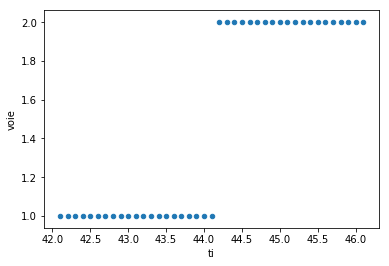

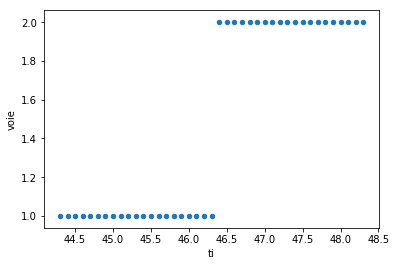

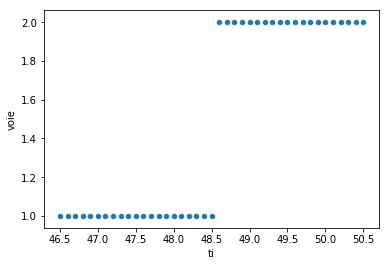

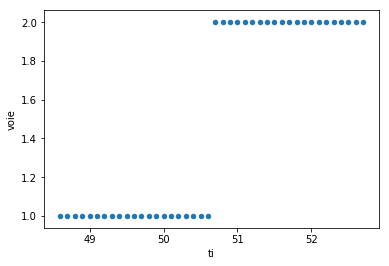

In [84]:
# Lane change time HDV
trajDf[(trajDf['type']=='HDV') & (trajDf['tron']=='Merge_zone')].groupby('id').plot(kind='scatter',x='ti',y='voie');
